# Churn Prediction Model on Amazon dataset

## Dataset Exploration And Preparation

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [127]:
df = pd.read_csv('/content/Amazon.csv')

In [128]:
df.shape

(4883, 14)

In [129]:
df.isnull().sum()

,0
product_id,0
product_name,0
Major Category,0
Sub Category,0
discounted_price,0
actual_price,0
discount_percentage,0
user_id,0
user_name,0
review_id,0


In [130]:
#dropping null rating count, review content, review title rows
df = df.dropna(subset=['rating_count','review_content', 'review_title'])
df.isnull().sum()

,0
product_id,0
product_name,0
Major Category,0
Sub Category,0
discounted_price,0
actual_price,0
discount_percentage,0
user_id,0
user_name,0
review_id,0


In [131]:
df.shape

(4777, 14)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4777 entries, 0 to 4882
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           4777 non-null   object
 1   product_name         4777 non-null   object
 2   Major Category       4777 non-null   object
 3   Sub Category         4777 non-null   object
 4   discounted_price     4777 non-null   object
 5   actual_price         4777 non-null   object
 6   discount_percentage  4777 non-null   object
 7   user_id              4777 non-null   object
 8   user_name            4777 non-null   object
 9   review_id            4777 non-null   object
 10  review_title         4777 non-null   object
 11  review_content       4777 non-null   object
 12  rating               4777 non-null   object
 13  rating_count         4777 non-null   object
dtypes: object(14)
memory usage: 559.8+ KB


In [133]:
df['Major Category'].value_counts()

,count
Major Category,
Electronics,1704
Home&Kitchen,1559
Computers&Accessories,1372
OfficeProducts,112
MusicalInstruments,10
HomeImprovement,10
Toys&Games,5
Health&PersonalCare,3
Car&Motorbike,2


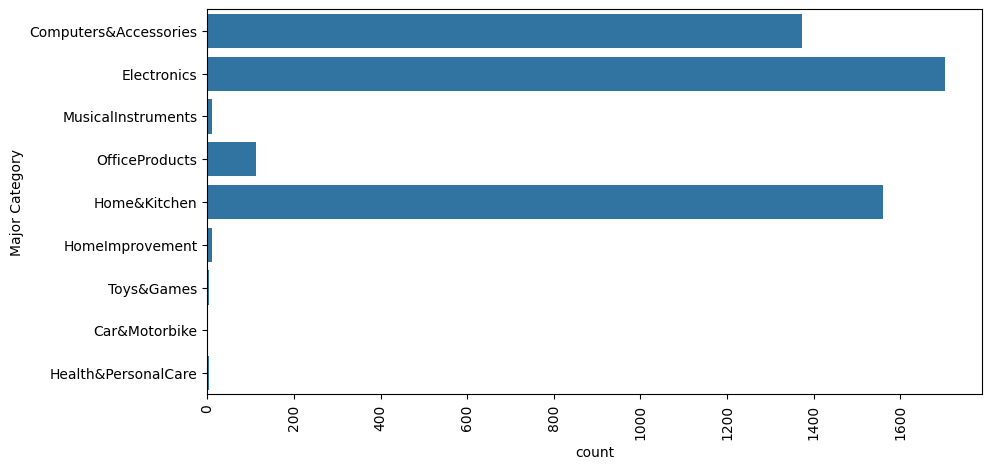

In [134]:
plt.figure(figsize=(10,5))
sns.countplot(df['Major Category'])
plt.xticks(rotation=90)
plt.show()

In [135]:
df['review_content'].sample(5).iloc[0]

'it may just break.Poor product design in 2022.'

## Text Preprocessing

## Cleaning Data
- Removing URLs,
- Removing hashtags,
- Removing special letters,
- Removing punctuations
- Removing emoji
- Removing stop words
- Lemmatization

In [136]:
df.head(1)

,product_id,product_name,Major Category,Sub Category,discounted_price,actual_price,discount_percentage,user_id,user_name,review_id,review_title,review_content,rating,rating_count
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,USBCables,₹399,"₹1,099",64%,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R3HXWT0LRP0NMF,Charging is really fast,Charging is really fast,4.2,"24,269"


In [137]:
# FEATURE EXTRACTION
df["review_text"] = df["review_title"] + " " + df["review_content"]

In [138]:
df.drop(['review_title', 'review_content'], axis=1, inplace=True)

In [139]:
!pip install emoji

In [140]:
# CLEANING DATA
import re
import emoji

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['review_text'] = df['review_text'].apply(clean_text)

In [141]:
# LEMMATIZATION
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

df['review_text'] = df['review_text'].apply(
    lambda x: ' '.join(lemmatizer.lemmatize(word) for word in str(x).split())
)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [142]:
df['review_text'].sample(5).values.tolist()

['good for typing the keyboard and mouse are good for typing and normal use cannot comment about battery life since ive used it only for a month sometimes mouse did not respond when laptop got hot while gaming hence not using the set for gaming',
 'perfect fit n finish but slightly over priced overall good and useful perfect fit n finish but slightly over priced overall good and useful',
 'perfect hdmi coupler work',
 'good good value of money if u have student at home',
 'rugged durable and compact']

### Sentiment Analysis

In [143]:
!pip install vaderSentiment

In [144]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [145]:
neg_df = df[df['sentiment_score'] < -0.05].copy()

## Text Vectorization

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(neg_df['review_text'])
required_text  = tfidf.transform(neg_df['review_text'])

In [147]:
required_text

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5208 stored elements and shape (503, 1865)>

In [148]:
neg_df.sample(1)

,product_id,product_name,Major Category,Sub Category,discounted_price,actual_price,discount_percentage,user_id,user_name,review_id,rating,rating_count,review_text,sentiment_score
2006,B01DEWVZ2C,"JBL C100SI Wired In Ear Headphones with Mic, J...",Electronics,In-Ear,₹599,₹999,40%,AFKLES3QOCRLIMJWHPEJVGK4RX3Q,Praveen Pavitrhran,R2NB2K5XC70FKP,4.1,"1,92,587",defective product delivered let see how long i...,-0.6908


## Forming Clusters

In [149]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)  # Try different k
neg_df['cluster'] = kmeans.fit_predict(required_text)

In [150]:
print(neg_df['cluster'].value_counts())

cluster
0    348
1    113
2     42
Name: count, dtype: int64


## Train Test Split

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(required_text, neg_df['cluster'], test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

0.801980198019802


## Cluster Values

In [152]:
import numpy as np

def get_top_keywords(kmeans_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    for i, center in enumerate(kmeans_model.cluster_centers_):
        print(f"\nCluster {i} top words:")
        top_indices = center.argsort()[-n_terms:][::-1]
        print(", ".join([terms[idx] for idx in top_indices]))

get_top_keywords(kmeans, tfidf)


Cluster 0 top words:
good, quality, working, wa, just, cable, use, bad, like, got

Cluster 1 top words:
product, good, bad, quality, wa, buy, worst, poor, average, working

Cluster 2 top words:
charging, sturdy, doe, support, cable, 33w, product, fast, good, working


### Churn Mapping From Clusters

In [153]:
cluster_sentiment = neg_df.groupby('cluster')['sentiment_score'].mean()
print("Average sentiment per cluster:\n", cluster_sentiment)

Average sentiment per cluster:
 cluster
0   -0.410432
1   -0.445081
2   -0.399498
Name: sentiment_score, dtype: float64


In [154]:
# Automatically assign churn = 1 if average sentiment of the cluster < -0.5
cluster_to_churn = {
    cluster: 1 if sentiment < -0.42 else 0
    for cluster, sentiment in cluster_sentiment.items()
}

print("Cluster to churn mapping:", cluster_to_churn)

Cluster to churn mapping: {0: 0, 1: 1, 2: 0}


In [155]:
def predict_churn(review_text):
    # Step 1: Transform the new review using the trained TF-IDF vectorizer
    vector = tfidf.transform([review_text])

    # Step 2: Predict cluster using the trained KNN classifier
    predicted_cluster = knn.predict(vector)[0]

    # Step 3: Map predicted cluster to churn using your learned mapping
    churn_label = cluster_to_churn.get(predicted_cluster, 0)  # default to 0 if cluster not found

    return churn_label

### Pediction System (Save The Model)

In [156]:
import pickle

with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

with open('knn.pkl', 'wb') as f:
    pickle.dump(knn, f)

with open('cluster_to_churn.pkl', 'wb') as f:
    pickle.dump(cluster_to_churn, f)

### Load The Model

In [157]:
with open('tfidf.pkl', 'rb') as f:
    tfidf = pickle.load(f)

with open('knn.pkl', 'rb') as f:
    knn = pickle.load(f)

with open('cluster_to_churn.pkl', 'rb') as f:
    cluster_to_churn = pickle.load(f)

### New Review

In [158]:
new_review = "The delivery was very late and the product quality is awful."
print("Predicted Churn:", predict_churn(new_review))

Predicted Churn: 1
